# 1. Preparação do notebook

In [ ]:
import pandas as pd
import numpy as np
from google.colab import files
from sklearn.preprocessing import RobustScaler
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
import warnings
import matplotlib.pyplot as plt

In [ ]:
# Oculta avisos específicos do NumPy
warnings.filterwarnings("ignore", category=UserWarning, module="numpy")

# 2. Leitura dos dados

In [ ]:
# Abertura da caixa de diálogo para selecionar o arquivo
uploaded = files.upload()

# Obtenção do nome do arquivo selecionado
filename = list(uploaded.keys())[0]

# Leitura do arquivo para um DataFrame
df = pd.read_excel(filename)

df.head()

Saving [BM Mean Reverting 10] Séries temporais.xlsx to [BM Mean Reverting 10] Séries temporais.xlsx


,bm_mean_reverting_10_W,bm_mean_reverting_10_MA,bm_mean_reverting_10_KS,bm_mean_reverting_10_SES,bm_mean_reverting_10_QES,bm_mean_reverting_10_SPLINES,bm_mean_reverting_10_LOWESS,bm_mean_reverting_10_RF,bm_mean_reverting_10_HP,bm_mean_reverting_10_KALMAN
0,100.000000,NaN,100.193479,100.000000,102.288785,100.000002,101.915847,100.000000,102.361348,100.000000
1,102.288785,NaN,101.571699,100.000000,103.822271,102.288774,101.889255,100.686635,102.336664,101.373271
2,102.224046,NaN,102.169024,100.686635,105.536342,102.224076,101.862641,101.147859,102.311979,101.896825
3,102.144690,NaN,102.684741,101.147859,106.617401,102.144639,101.836004,101.446908,102.287294,102.049918
4,103.228416,101.977187,103.901191,101.446908,107.216154,103.228454,101.809346,101.981360,102.262608,102.778203


# 3. Previsão da série temporal

## 3.1. Criação de janelas deslizantes

In [ ]:
# Função para criar janelas deslizantes
def create_sliding_windows(series, window_size):
    X, y = [], []
    for i in range(len(series) - window_size):
        X.append(series[i:i + window_size])
        y.append(series[i + window_size])
    return np.array(X), np.array(y)

In [ ]:
# Seleção da série
series = df['regime_switching_1_MA'].dropna().values

# Criação da janela deslizante
window_size = 1
X, y = create_sliding_windows(series, window_size)

In [ ]:
X

array([[101.97718737],
       [103.30068436],
       [104.13268778],
       ...,
       [ 93.81188369],
       [ 91.74746346],
       [ 95.69192066]])

In [ ]:
y

array([103.30068436, 104.13268778, 104.3167947 , ...,  91.74746346,
        95.69192066,  96.55944472])

## 3.2. Normalização

In [ ]:
# Função para normalização Min-Max
def normalize_series(series):
    scaler = RobustScaler()
    series_scaled = scaler.fit_transform(series.reshape(-1, 1)).flatten()
    return series_scaled, scaler

In [ ]:
# Normalização dos dados
X_scaled, scaler_X = normalize_series(X.flatten())
y_scaled, scaler_y = normalize_series(y)

X_scaled = X_scaled.reshape(-1, window_size)

## 3.2. Treinamento do modelo

In [ ]:
# Definição do modelo Conv1D
class Conv1DModel(nn.Module):
    def __init__(self, input_size, num_filters=16, kernel_size=3):
        super(Conv1DModel, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=num_filters, kernel_size=min(kernel_size, input_size), padding=0)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(num_filters * (input_size - min(kernel_size, input_size) + 1), 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

# Função para treinar Conv1D com otimização de hiperparâmetros
def train_conv1d(X_train, y_train, input_size):
    best_model = None
    best_loss = float('inf')
    param_grid = {
        'num_filters': [8, 16, 32],
        'kernel_size': [3, 5]
    }

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    for num_filters in param_grid['num_filters']:
        for kernel_size in param_grid['kernel_size']:
            kernel_size = min(kernel_size, input_size)  # Ajustar tamanho do kernel
            model = Conv1DModel(input_size, num_filters, kernel_size).to(device)
            criterion = nn.SmoothL1Loss(beta=1.0)
            optimizer = optim.Adam(model.parameters(), lr=0.001)

            X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1).to(device)
            y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1).to(device)

            for epoch in range(100):
                model.train()
                optimizer.zero_grad()
                outputs = model(X_train_tensor)
                loss = criterion(outputs, y_train_tensor)
                loss.backward()
                optimizer.step()

                if loss.item() < best_loss:
                    best_loss = loss.item()
                    best_model = model

    return best_model

In [ ]:
# Divisão entre treino e teste (70% treino, 30% teste)
split_idx = int(0.7 * len(X_scaled))
X_train, X_test = X_scaled[:split_idx], X_scaled[split_idx:]
y_train, y_test = y_scaled[:split_idx], y_scaled[split_idx:]

# Treinamento do modelo ELM
conv1d_model = train_conv1d(X_train, y_train, input_size=1)

## 3.3. Avaliação do modelo

In [ ]:
# Previsões no conjunto de treino
y_train_pred_scaled = conv1d_model(torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)).detach().numpy().flatten()
y_train_pred = scaler_y.inverse_transform(y_train_pred_scaled.reshape(-1, 1)).flatten()

# Previsões no conjunto de teste
y_test_pred_scaled = conv1d_model(torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)).detach().numpy().flatten()
y_test_pred = scaler_y.inverse_transform(y_test_pred_scaled.reshape(-1, 1)).flatten()

# DataFrames com previsões
train_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_train.reshape(-1, 1)).flatten(),
                              'Predicted': y_train_pred})

test_results = pd.DataFrame({'Actual': scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten(),
                             'Predicted': y_test_pred})

In [ ]:
# Cálculo do sMAPE
def smape(actual, predicted):
    return 100 * np.mean(2 * np.abs(predicted - actual) / (np.abs(actual) + np.abs(predicted)))

smape_train = smape(train_results['Actual'].values, train_results['Predicted'].values)
smape_test = smape(test_results['Actual'].values, test_results['Predicted'].values)

print(f'sMAPE Treino: {smape_train:.2f}%')
print(f'sMAPE Teste: {smape_test:.2f}%')

sMAPE Treino: 2.08%
sMAPE Teste: 3.98%


In [ ]:
# Cálculo do RMSE
def rmse(actual, predicted):
    return np.sqrt(np.mean((predicted - actual) ** 2))

rmse_train = rmse(train_results['Actual'].values, train_results['Predicted'].values)
rmse_test = rmse(test_results['Actual'].values, test_results['Predicted'].values)

print(f'RMSE Treino: {rmse_train:.2f}')
print(f'RMSE Teste: {rmse_test:.2f}')

RMSE Treino: 2.55
RMSE Teste: 6.95


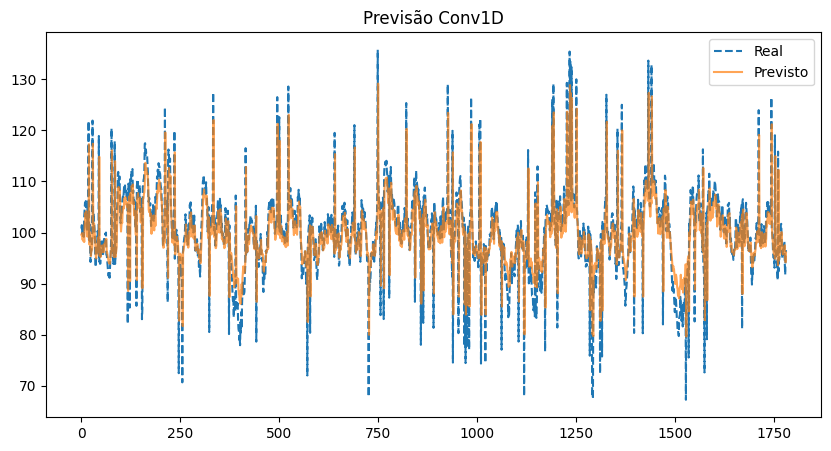

In [ ]:
# Gráfico Real x Previsto
plt.figure(figsize=(10, 5))
plt.plot(test_results['Actual'], label='Real', linestyle='dashed')
plt.plot(test_results['Predicted'], label='Previsto', alpha=0.7)
plt.legend()
#plt.title(f'Previsão Conv1D - sMAPE (dados de teste): {smape_test:.2f}%')
plt.title(f'Previsão Conv1D')
plt.show()

# 4. Análise dos erros

In [ ]:
results = pd.concat([train_results, test_results])
results['Error'] = results['Actual'] - results['Predicted']

Q1 = results['Actual'].quantile(0.25)
Q3 = results['Actual'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = results[(results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)]
outliers

,Actual,Predicted,Error
1415,118.956841,113.460335,5.496506
1416,120.304553,114.893829,5.410724
1417,121.225296,116.026840,5.198456
1418,121.323359,116.800903,4.522455
1419,120.931305,116.883347,4.047959
...,...,...,...
1581,79.112248,101.876007,-22.763759
1670,81.183737,103.523872,-22.340135
1712,123.954794,101.240456,22.714338
1744,126.404748,101.676918,24.727830


In [ ]:
# Identifica os outliers
results['Outlier'] = (results['Actual'] < lower_bound) | (results['Actual'] > upper_bound)
results.head()

,Actual,Predicted,Error,Outlier
0,103.300684,100.304726,2.995959,False
1,104.132688,101.343315,2.789373,False
2,104.316795,102.108208,2.208587,False
3,104.958101,102.277466,2.680635,False
4,104.786224,102.929115,1.857109,False


In [ ]:
# Teste de Mann-Whitney
from scipy.stats import mannwhitneyu

# Separa os erros dos dois grupos
erros_outliers = results[results['Outlier']]['Error']
erros_normais = results[~results['Outlier']]['Error']

# Aplicação do teste de Mann-Whitney
stat, p = mannwhitneyu(erros_outliers, erros_normais, alternative='greater')

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 294730.0
Valor-p: 0.7455977042668742
Não há evidência suficiente para afirmar que os outliers causam maiores erros.


In [ ]:
# Teste de Kruskal-Wallis
from scipy.stats import kruskal

# Classificação dos pontos
results['Grupo'] = 'normal'
results.loc[results['Actual'] < lower_bound, 'Grupo'] = 'outlier_negativo'
results.loc[results['Actual'] > upper_bound, 'Grupo'] = 'outlier_positivo'

# Separa os erros por grupo
erros_normais = results[results['Grupo'] == 'normal']['Error']
erros_outliers_neg = results[results['Grupo'] == 'outlier_negativo']['Error']
erros_outliers_pos = results[results['Grupo'] == 'outlier_positivo']['Error']

# Aplicação do teste de Kruskal-Wallis
stat, p = kruskal(erros_normais, erros_outliers_neg, erros_outliers_pos)

# Exibir resultados
print(f"Estatística U: {stat}")
print(f"Valor-p: {p}")

if p < 0.05:
    print("Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.")
else:
    print("Não há evidência suficiente para afirmar que os outliers causam maiores erros.")

Estatística U: 297.60134158035
Valor-p: 2.3806183251826535e-65
Rejeitamos a hipótese nula: os erros nos outliers são significativamente maiores.


In [ ]:
# Análise da correlação de Spearman
from scipy.stats import spearmanr

# Calcular a correlação de Spearman
correlacao, p_valor = spearmanr(results['Outlier'], results['Error'])

# Exibir resultados
print(f"Correlação: {correlacao}")
print(f"Valor-p: {p_valor}")

if p_valor < 0.05:
    print("Existe uma relação significativa entre outliers e a magnitude do erro.")
else:
    print("Não há evidência estatística de que os outliers impactam significativamente os erros.")

Correlação: -0.008574366444566807
Valor-p: 0.5088687628211906
Não há evidência estatística de que os outliers impactam significativamente os erros.
